# WeightWatcher DenseNet





### Key Idea in DenseNet 

Dense Connections: connect back to all previous Conv2d feature maps from all previous layers

https://www.jeremyjordan.me/convnet-architectures/#densenet

*"concatenating feature-maps learned by different layers increases variation in the input of subsequent layers and improves efficiency."*



## Summary of Results

A great example of where the $\hat{\alpha}$ does not correlated at all, but the new p-Norm metric does.



In [1]:
REPEAT = False # set true to rerun weightwatcher calculations from scratch
SAVE_DATA = False # DO NOT set True unless you want to replace all files in ./data

In [2]:
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


%load_ext watermark
%watermark

Last updated: 2021-01-08T21:07:15.939306-08:00

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.11.1

Compiler    : Clang 4.0.1 (tags/RELEASE_401/final)
OS          : Darwin
Release     : 17.7.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit



### Import WeightWatcher

set custom Logging at WARN Level

In [3]:
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
logger.setLevel(logging.WARN)

import weightwatcher as ww
import torchvision.models as models

ww.__version__


Using TensorFlow backend.


'0.2.7'

###  Helper Notebook to make Plots


In [4]:
import import_ipynb
import ModelPlots as MP

importing Jupyter notebook from ModelPlots.ipynb


### Create all models now

In [5]:
series_name = 'DenseNet'
all_names = [ 'densenet121', 'densenet169', 'densenet201', 'densenet161']
colors = ['blue', 'green', 'teal', 'red']

In [6]:
all_models = []
all_models.append(models.densenet121(pretrained=True))
all_models.append(models.densenet161(pretrained=True))
all_models.append(models.densenet169(pretrained=True))
all_models.append(models.densenet201(pretrained=True))


### Get reported accuracies from pytorch website

https://pytorch.org/docs/stable/torchvision/models.html


<pre>
<table class="docutils align-default">
<colgroup>
<col style="width: 55%" />
<col style="width: 22%" />
<col style="width: 22%" />
</colgroup>
<thead>
<thead>
<tr class="row-odd"><th class="head"><p>Network</p></th>
<th class="head"><p>Top-1 error</p></th>
<th class="head"><p>Top-5 error</p></th>
</tr>
</thead>
<tbody>

<tr class="row-even"><td><p>Densenet-121</p></td>
<td><p>25.35</p></td>
<td><p>7.83</p></td>
</tr>
<tr class="row-odd"><td><p>Densenet-169</p></td>
<td><p>24.00</p></td>
<td><p>7.00</p></td>
</tr>
<tr class="row-even"><td><p>Densenet-201</p></td>
<td><p>22.80</p></td>
<td><p>6.43</p></td>
</tr>
<tr class="row-odd"><td><p>Densenet-161</p></td>
<td><p>22.35</p></td>
<td><p>6.20</p></td>
</tr>

</tbody>
</table>
</pre>

In [7]:
top1_errors= {
    
    "densenet121": 25.35,
    "densenet169": 24.00,
    "densenet201": 22.80,
    "densenet161": 22.35 

}

In [8]:
top5_errors= {
    
    "densenet121": 7.83,
    "densenet169": 7.00,
    "densenet201": 6.43,
    "densenet161": 6.20 

}

## Run WeightWatcher, collect summary and details (as dataframes) for all models

In [9]:
all_details = []
all_summaries = []
if REPEAT:
    for im, name in enumerate(tqdm(all_names)):
        watcher = ww.WeightWatcher(model=all_models[im], logger=logger)
        results = watcher.analyze(alphas=True, softranks=True, spectralnorms=True, mp_fit=True,
                                 normalize=False, glorot_fix=False)

        summary =  watcher.get_summary()

        details  = watcher.get_details(results=results)
        details.drop(columns=['slice', 'slice_count'], inplace=True)
        details.dropna(inplace=True)
        details['NxM'] = pd.to_numeric(details.N * details.M)

        details.rename(columns=MP.WW4X_COMPAT_COLUMNS, inplace=True)
        all_details.append(details)

        for k,v in MP.WW4X_COMPAT_COLUMNS.items():
            summary[v]=summary[k]
        all_summaries.append(summary)
else:
    all_details, all_summaries = MP.read_ww2x_data(all_names, datadir='data')
    
if SAVE_DATA:
    MP.save_ww2x_data(all_names,all_details, all_summaries, datadir='data')

loading details in data/densenet121.csv
loading details in data/densenet169.csv
loading details in data/densenet201.csv
loading details in data/densenet161.csv
loading summary in  data/densenet121.txt
loading summary in  data/densenet169.txt
loading summary in  data/densenet201.txt
loading summary in  data/densenet161.txt


In [10]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [11]:
first_n_last_ids = [0, len(all_details)-1]

saving img/DenseNet_log_norm_accs.png


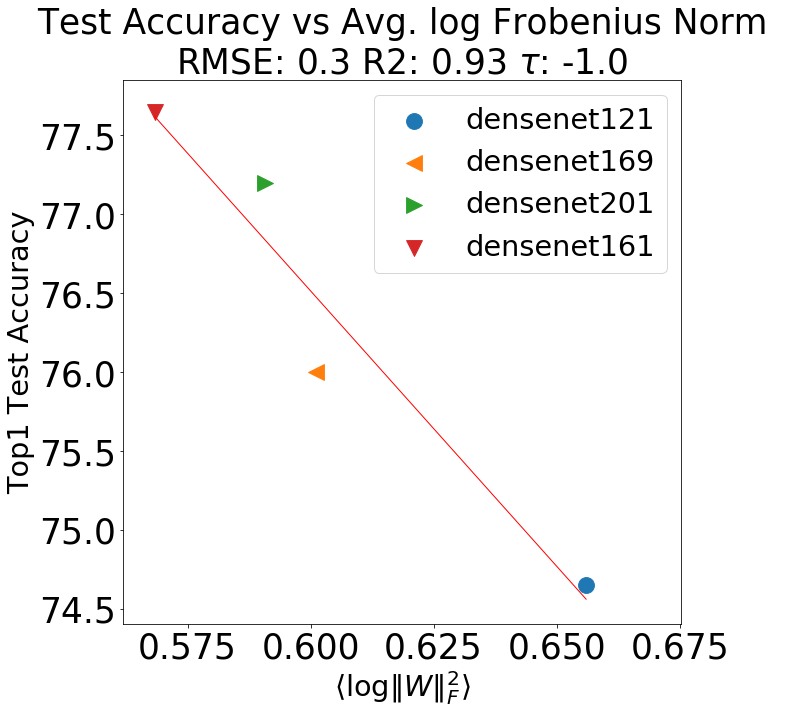

saving img/DenseNet_alpha_accs.png


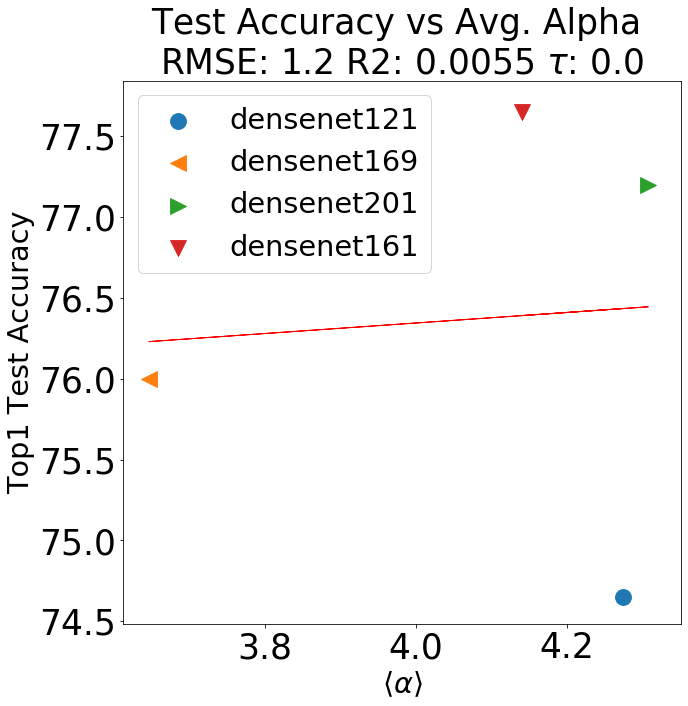

saving img/DenseNet_alpha_weighted_accs.png


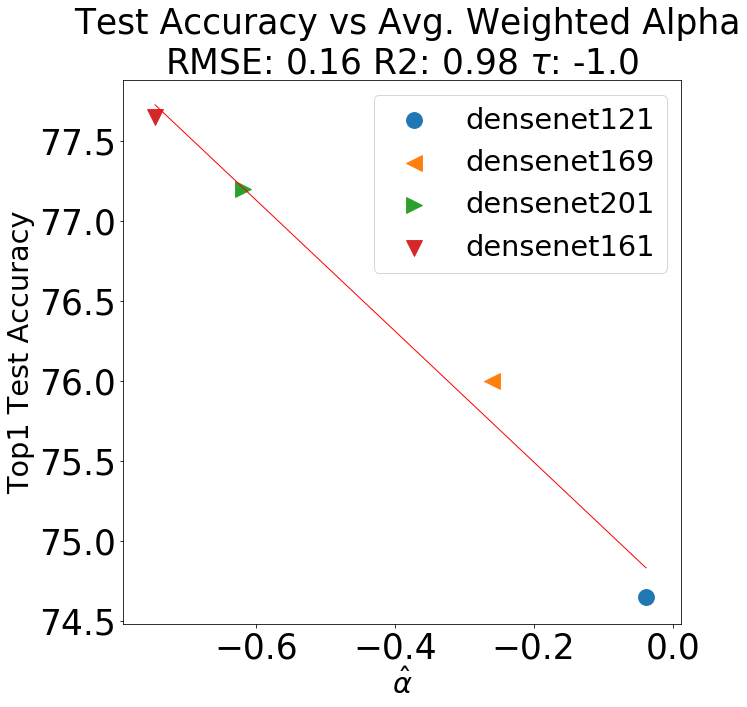

saving img/DenseNet_log_spectral_norm_accs.png


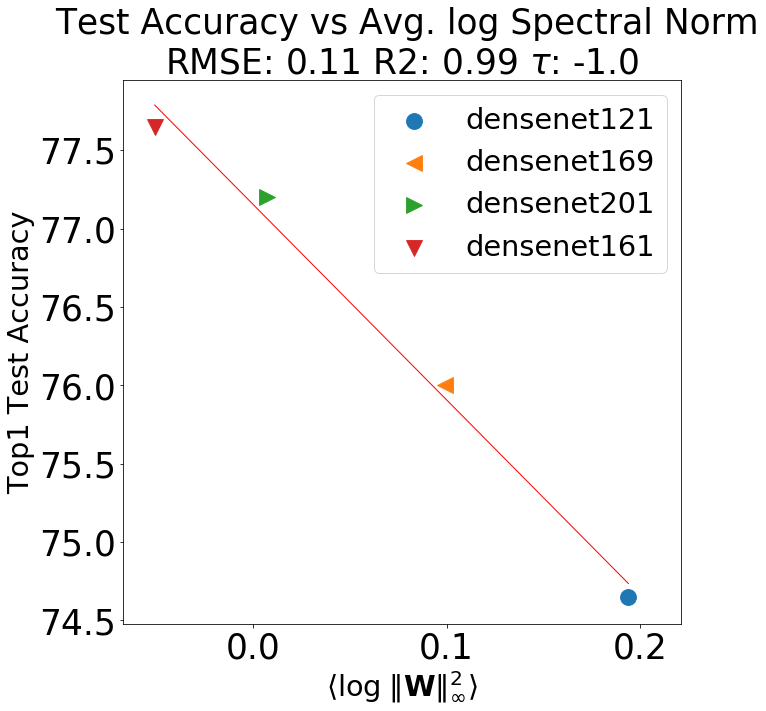

saving img/DenseNet_log_stable_rank_accs.png


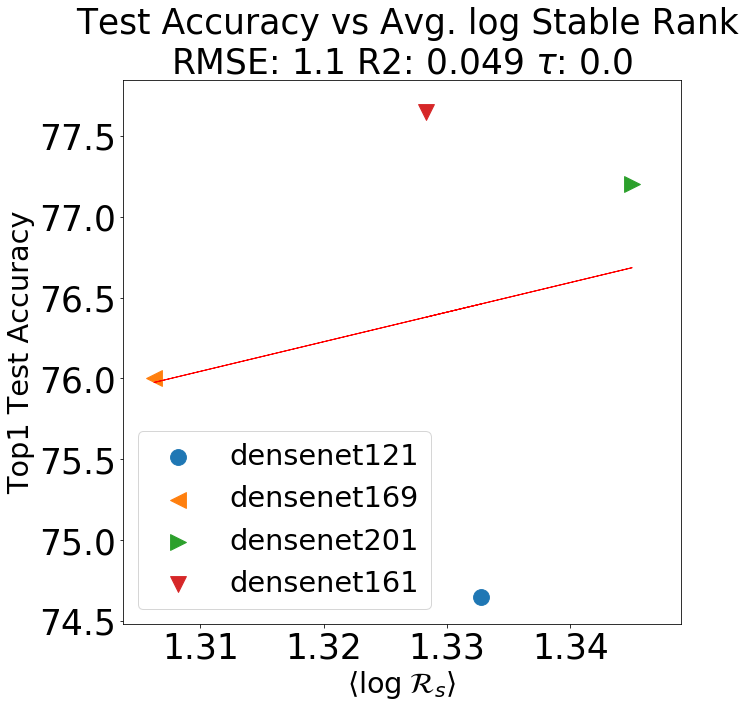

saving img/DenseNet_mp_softrank_accs.png


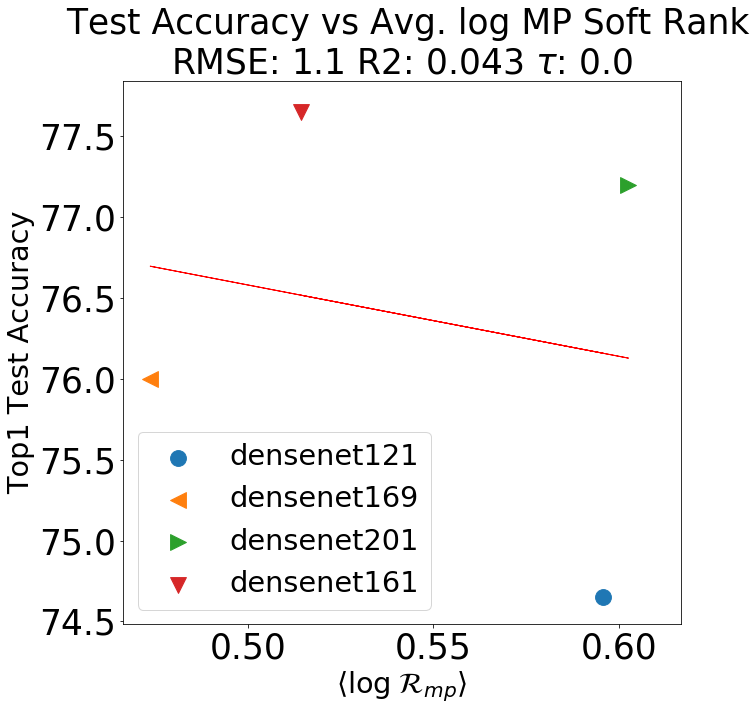

saving img/DenseNet_log_alpha_norm_accs.png


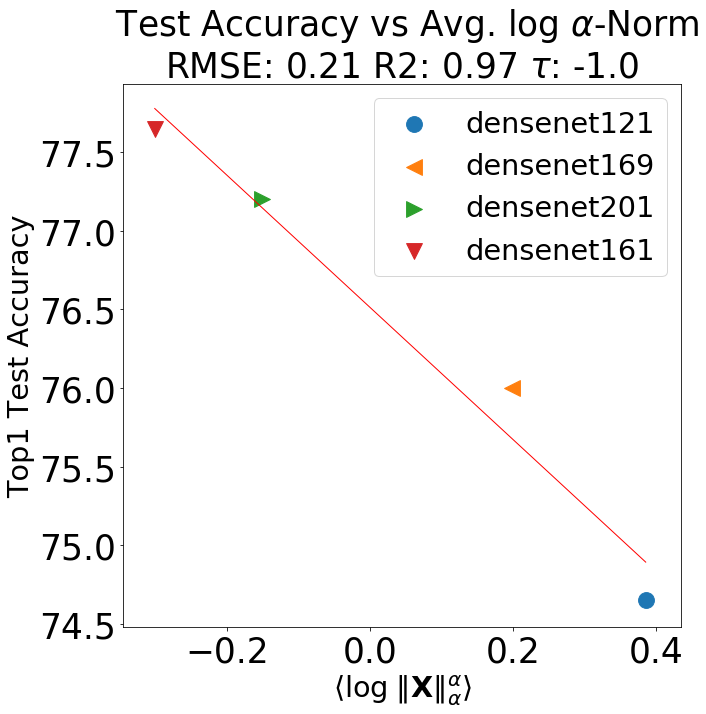

In [12]:
MP.plot_all_metrics_vs_test_accuracies( \
    series_name, all_names, colors, all_summaries, all_details, top1_errors)

DenseNet log_norm densenet121 median = 0.65
DenseNet log_norm densenet169 median = 0.626
DenseNet log_norm densenet201 median = 0.601
saving img/DenseNet_all_log_norm_hist.png


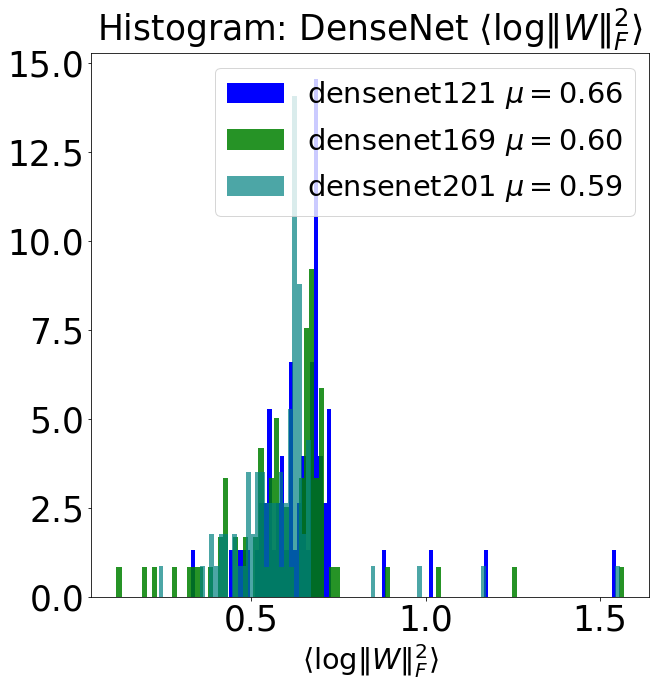

DenseNet log_norm densenet121 median = 0.65
DenseNet log_norm densenet161 median = 0.583
saving img/DenseNet_fnl_log_norm_hist.png


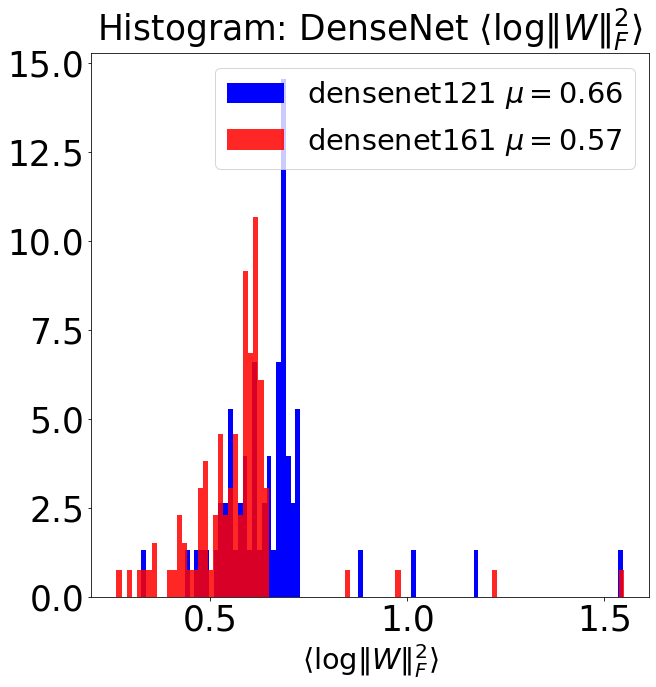

DenseNet alpha densenet121 median = 4.44
DenseNet alpha densenet169 median = 3.45
DenseNet alpha densenet201 median = 3.94
saving img/DenseNet_all_alpha_hist.png


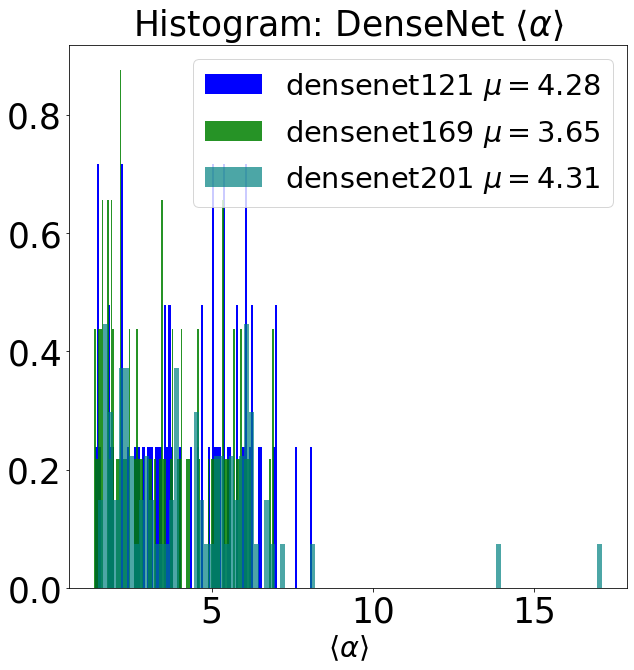

DenseNet alpha densenet121 median = 4.44
DenseNet alpha densenet161 median = 3.96
saving img/DenseNet_fnl_alpha_hist.png


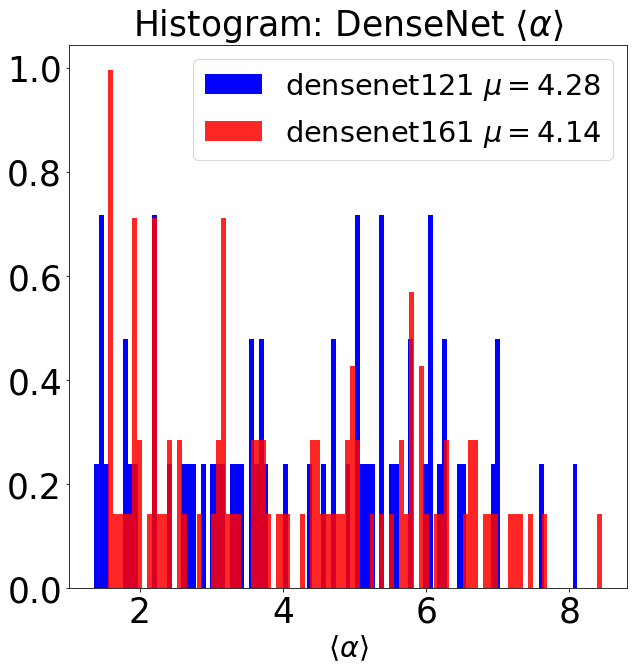

DenseNet alpha_weighted densenet121 median = -0.141
DenseNet alpha_weighted densenet169 median = -0.298
DenseNet alpha_weighted densenet201 median = -0.782
saving img/DenseNet_all_alpha_weighted_hist.png


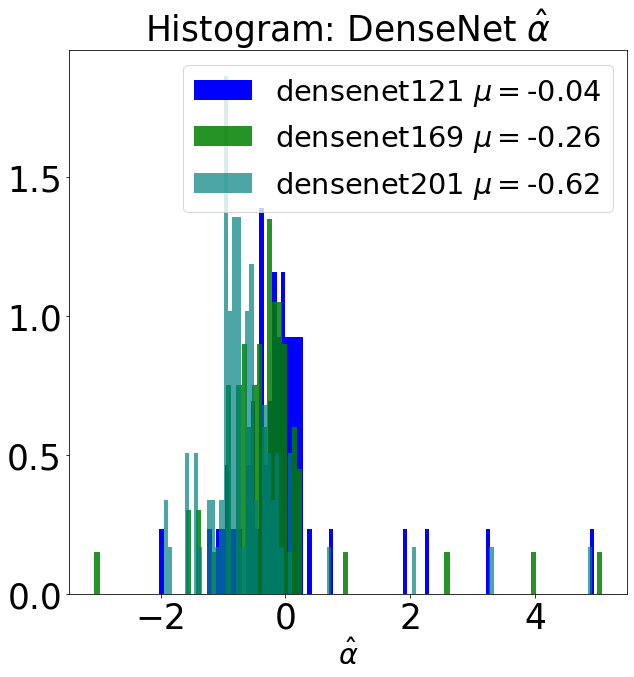

DenseNet alpha_weighted densenet121 median = -0.141
DenseNet alpha_weighted densenet161 median = -0.824
saving img/DenseNet_fnl_alpha_weighted_hist.png


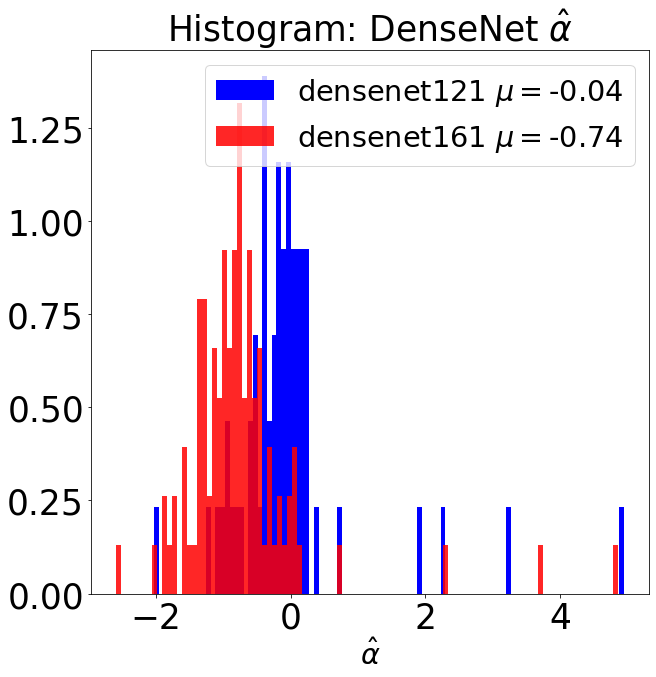

DenseNet log_stable_rank densenet121 median = 1.35
DenseNet log_stable_rank densenet169 median = 1.35
DenseNet log_stable_rank densenet201 median = 1.37
saving img/DenseNet_all_log_stable_rank_hist.png


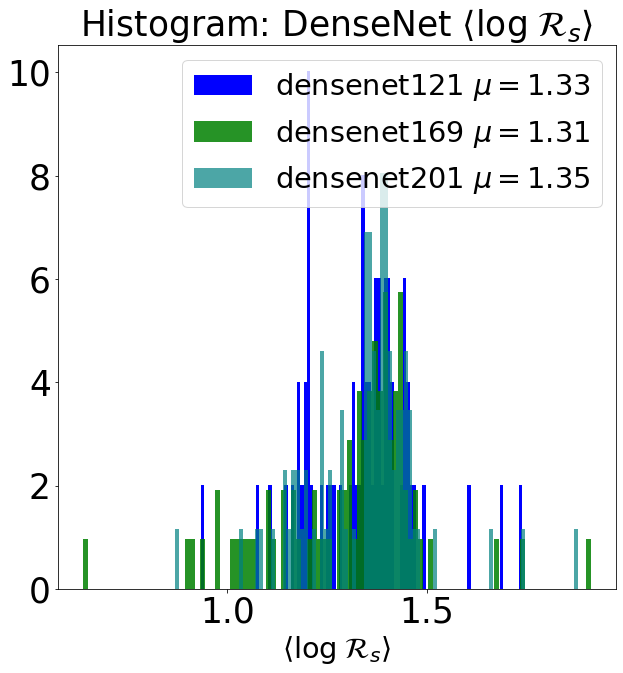

DenseNet log_stable_rank densenet121 median = 1.35
DenseNet log_stable_rank densenet161 median = 1.37
saving img/DenseNet_fnl_log_stable_rank_hist.png


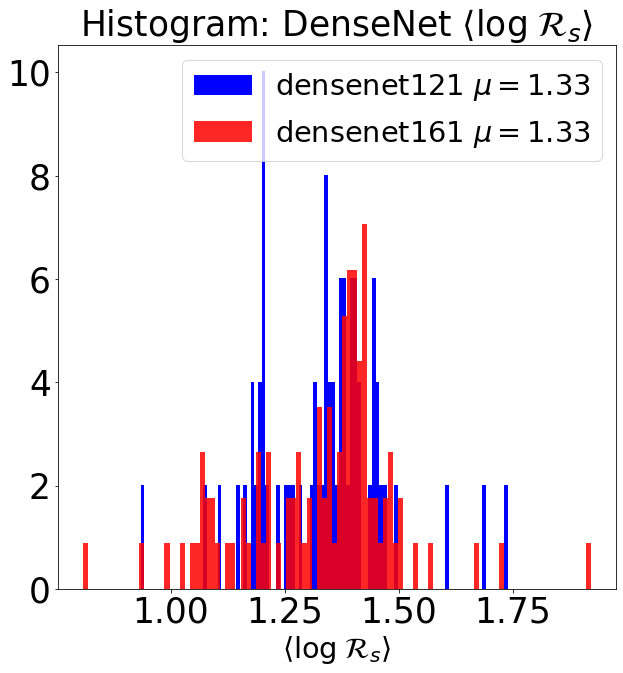

DenseNet log_spectral_norm densenet121 median = -0.0307
DenseNet log_spectral_norm densenet169 median = -0.0843
DenseNet log_spectral_norm densenet201 median = -0.171
saving img/DenseNet_all_log_spectral_norm_hist.png


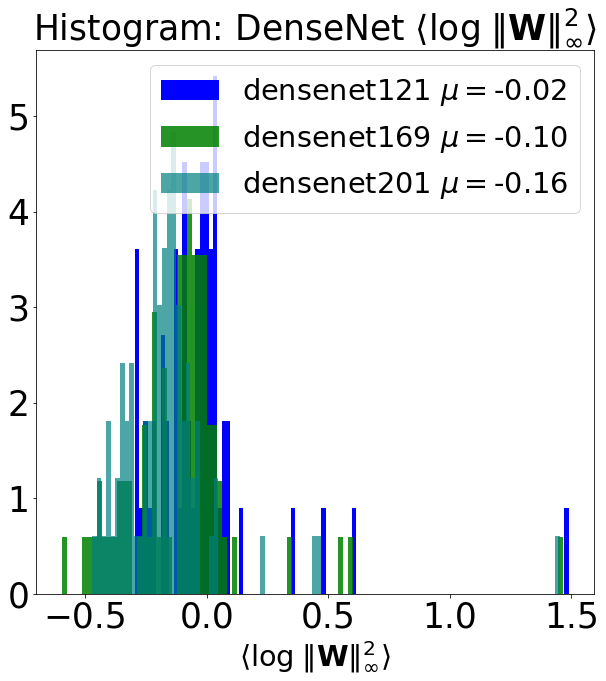

DenseNet log_spectral_norm densenet121 median = -0.0307
DenseNet log_spectral_norm densenet161 median = -0.208
saving img/DenseNet_fnl_log_spectral_norm_hist.png


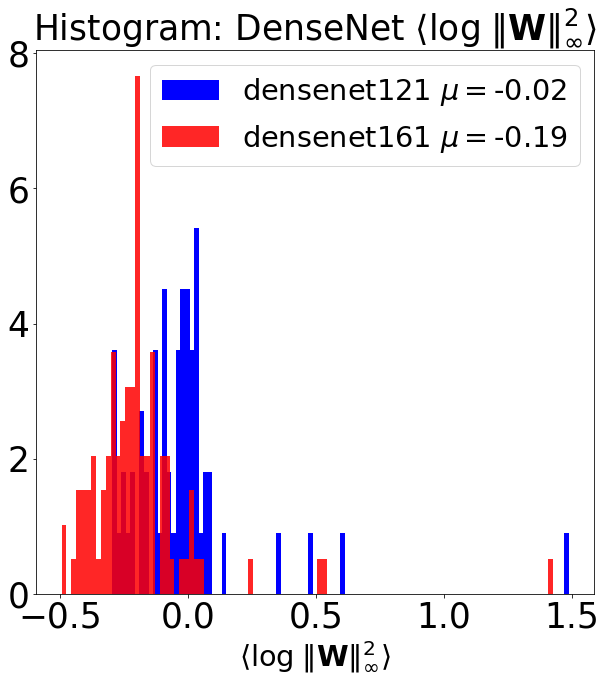

DenseNet mp_softrank densenet121 median = 0.413
DenseNet mp_softrank densenet169 median = 0.285
DenseNet mp_softrank densenet201 median = 0.409
saving img/DenseNet_all_mp_softrank_hist.png


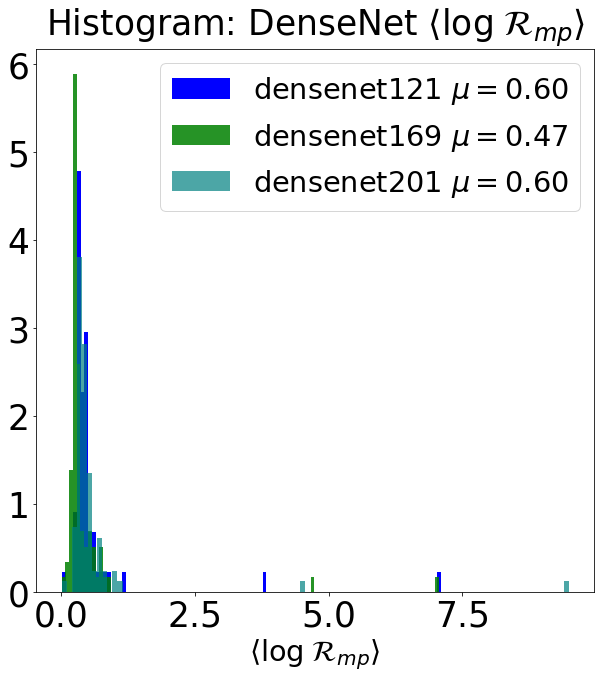

DenseNet mp_softrank densenet121 median = 0.413
DenseNet mp_softrank densenet161 median = 0.393
saving img/DenseNet_fnl_mp_softrank_hist.png


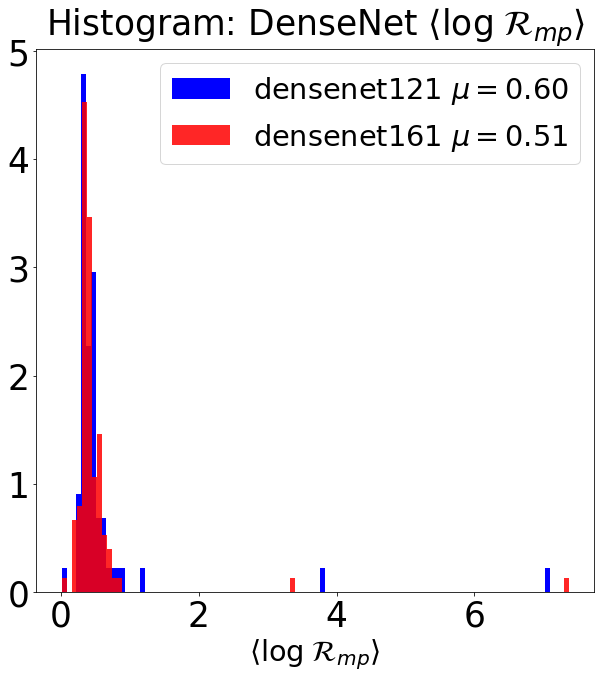

DenseNet log_alpha_norm densenet121 median = 0.295
DenseNet log_alpha_norm densenet169 median = 0.148
DenseNet log_alpha_norm densenet201 median = -0.279
saving img/DenseNet_all_log_alpha_norm_hist.png


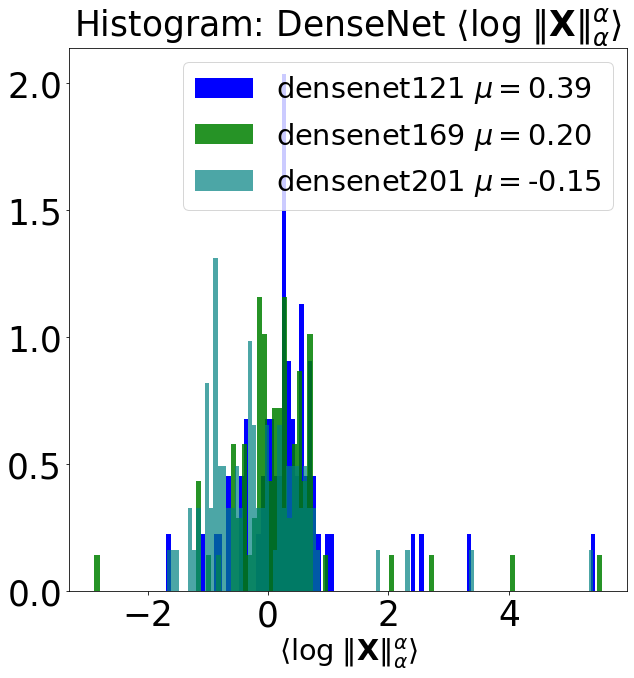

DenseNet log_alpha_norm densenet121 median = 0.295
DenseNet log_alpha_norm densenet161 median = -0.323
saving img/DenseNet_fnl_log_alpha_norm_hist.png


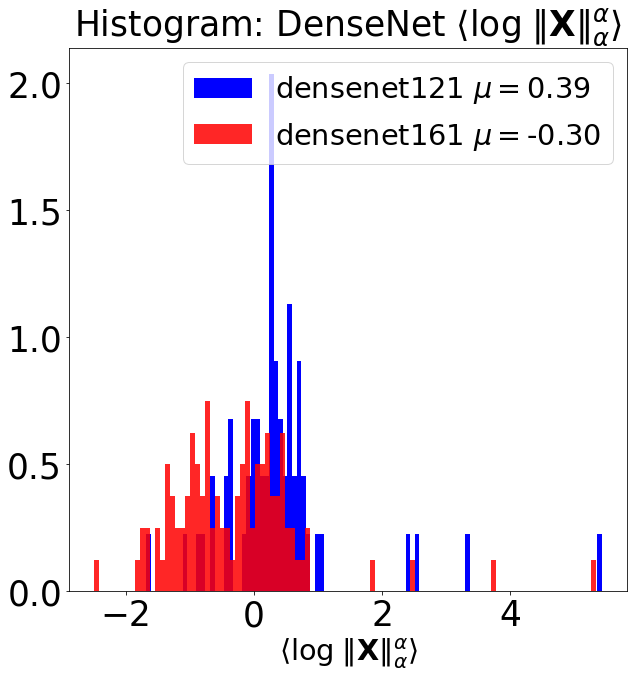

In [13]:
MP.plot_all_metric_histograms( \
    series_name, all_names, colors, all_summaries, all_details, first_n_last_ids)

saving img/DenseNet_all_log_norm_depth.png


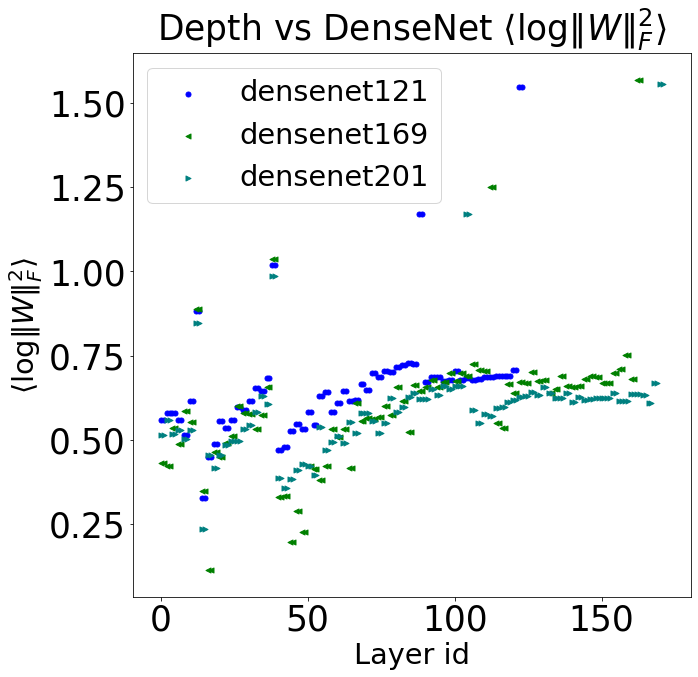

saving img/DenseNet_fnl_log_norm_depth.png


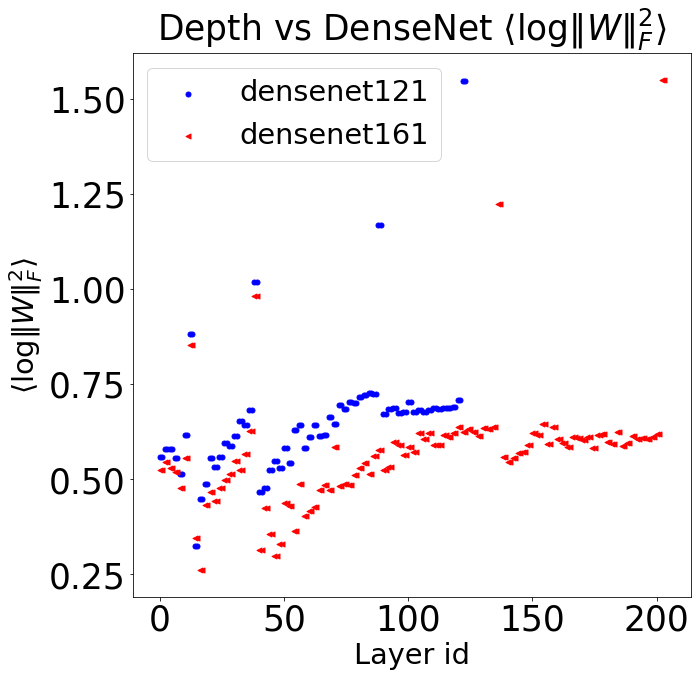

saving img/DenseNet_all_alpha_depth.png


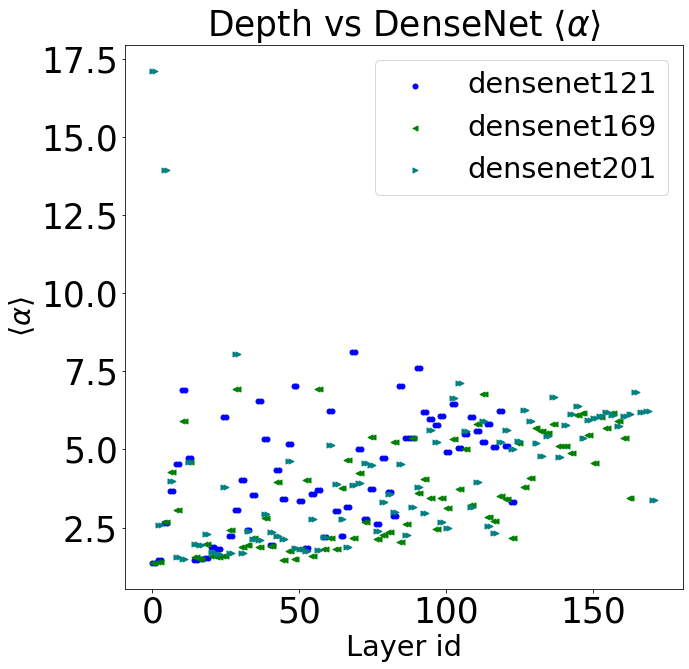

saving img/DenseNet_fnl_alpha_depth.png


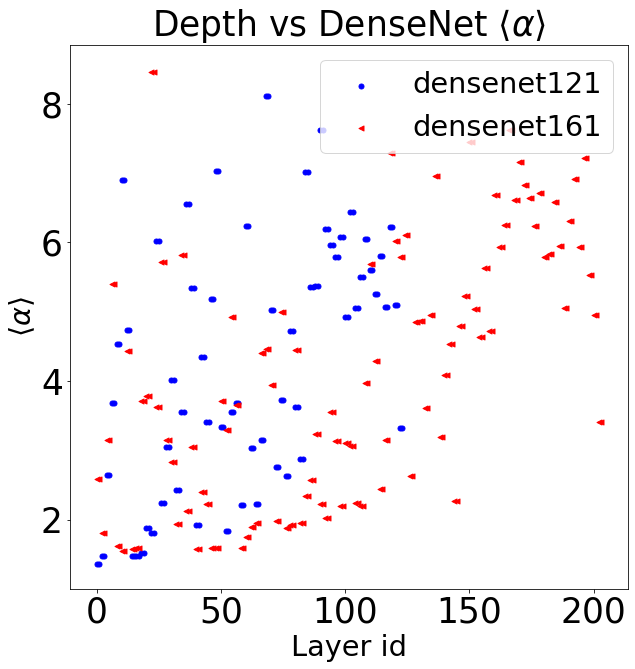

saving img/DenseNet_all_alpha_weighted_depth.png


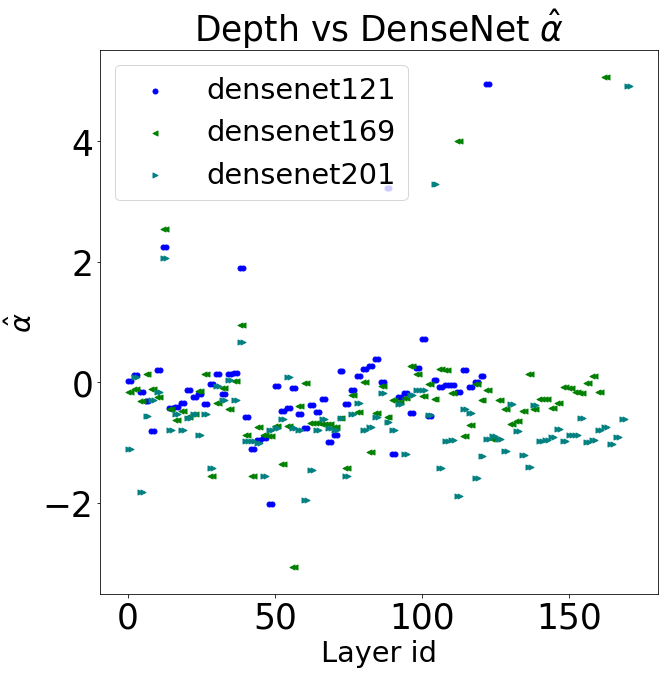

saving img/DenseNet_fnl_alpha_weighted_depth.png


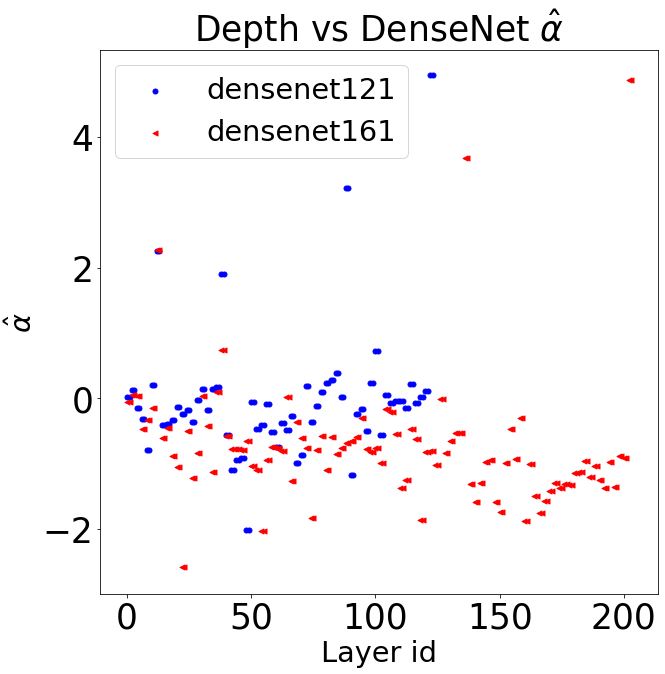

saving img/DenseNet_all_log_stable_rank_depth.png


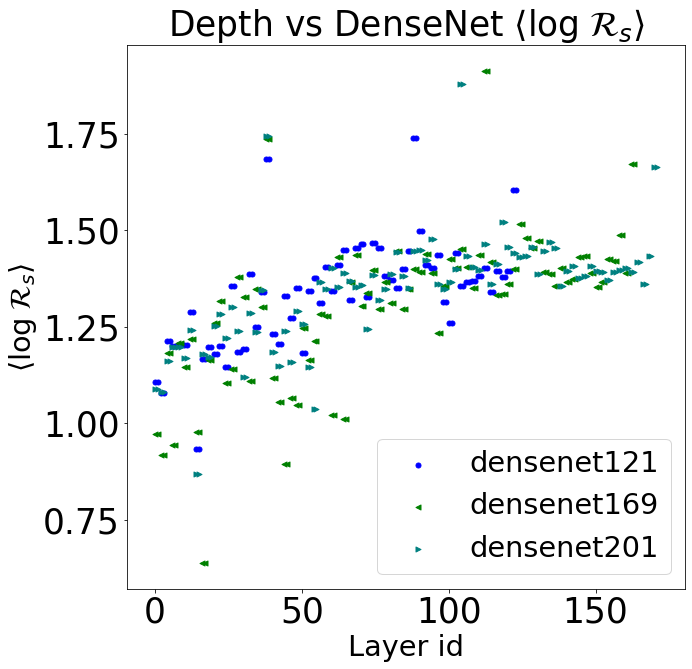

saving img/DenseNet_fnl_log_stable_rank_depth.png


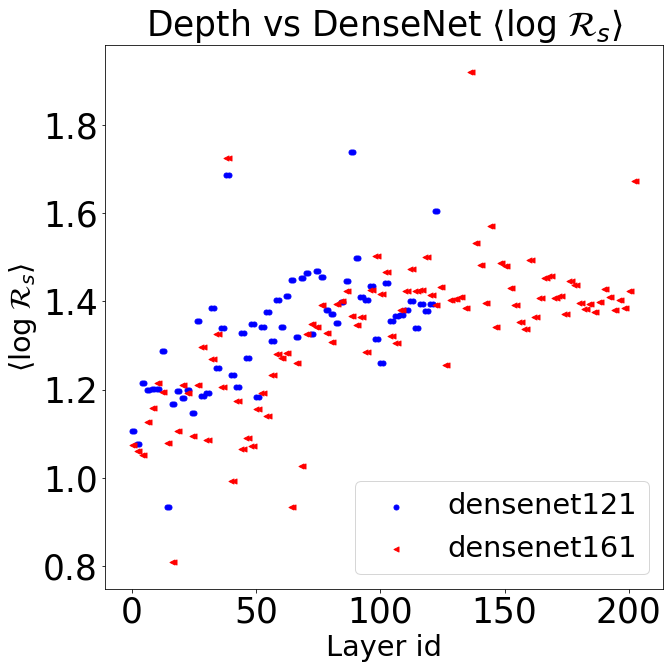

saving img/DenseNet_all_log_spectral_norm_depth.png


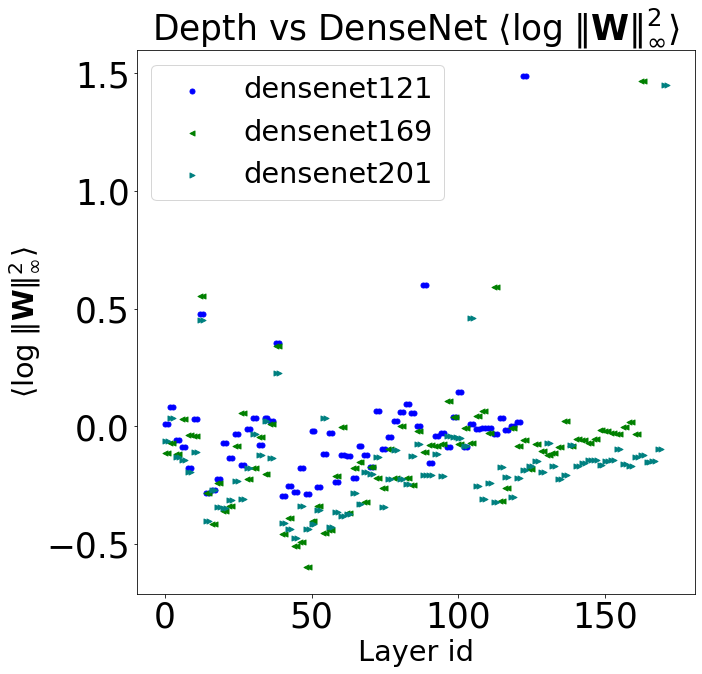

saving img/DenseNet_fnl_log_spectral_norm_depth.png


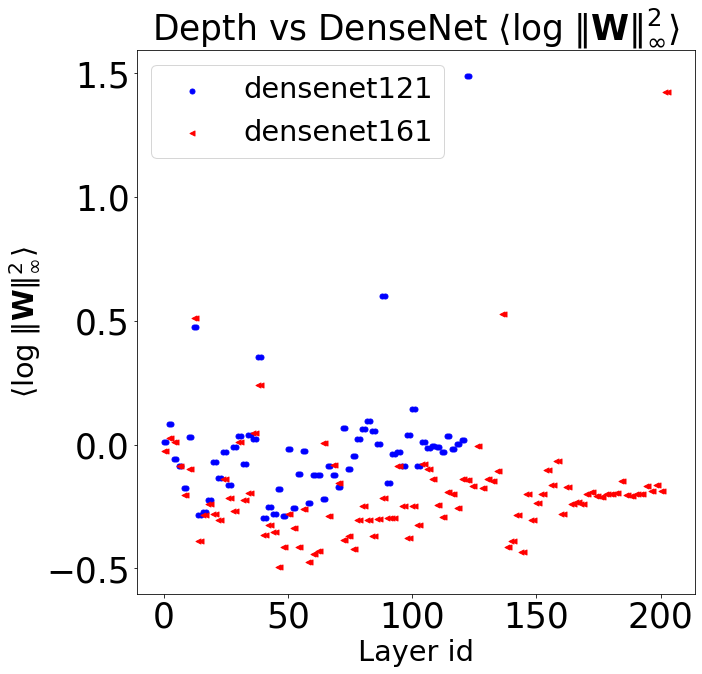

saving img/DenseNet_all_mp_softrank_depth.png


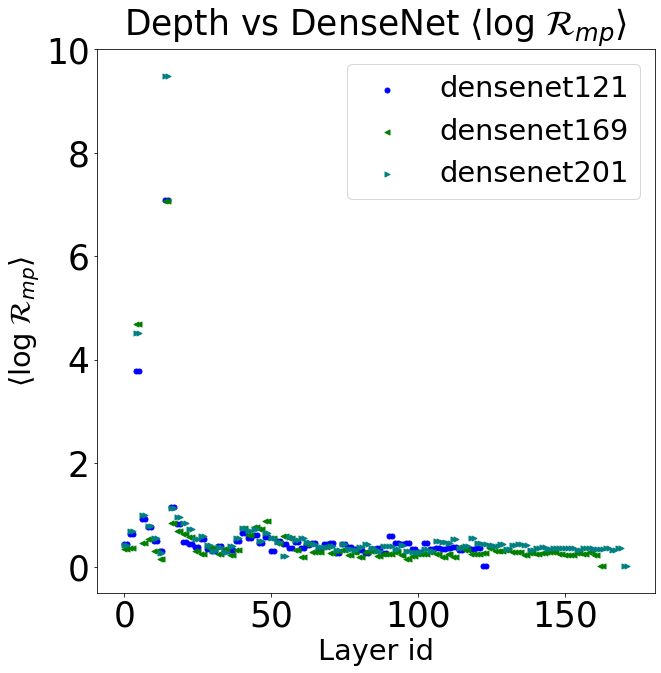

saving img/DenseNet_fnl_mp_softrank_depth.png


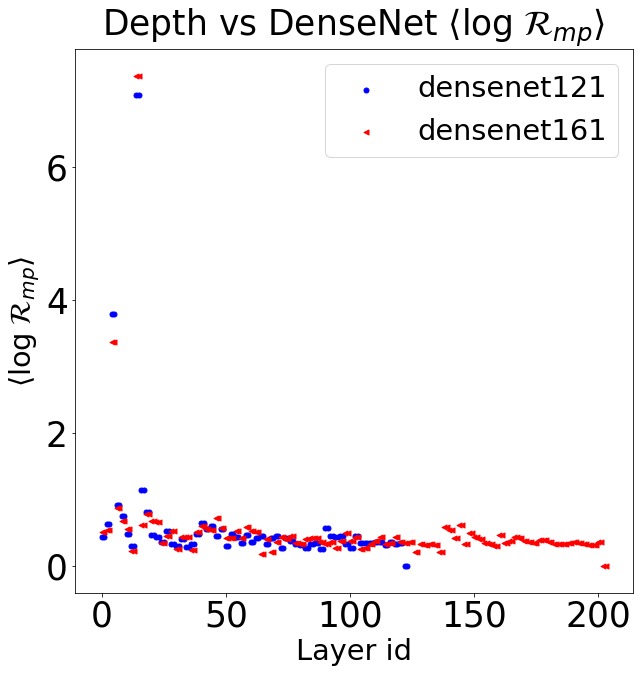

saving img/DenseNet_all_log_alpha_norm_depth.png


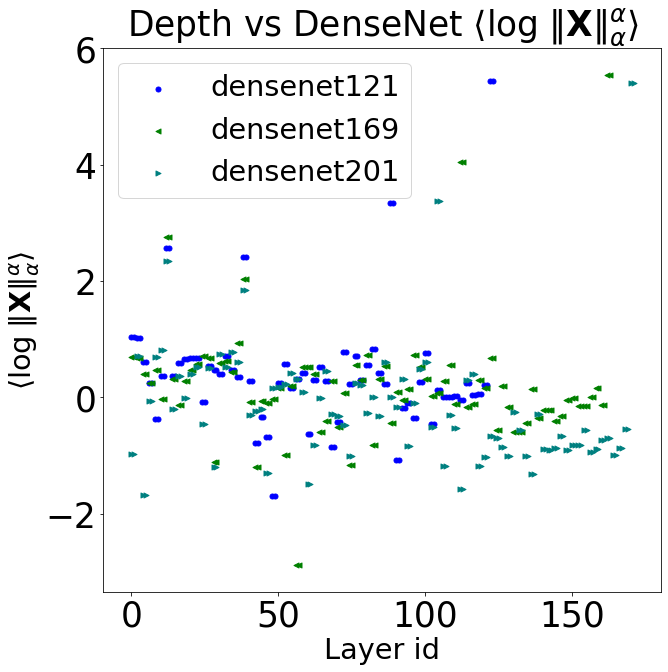

saving img/DenseNet_fnl_log_alpha_norm_depth.png


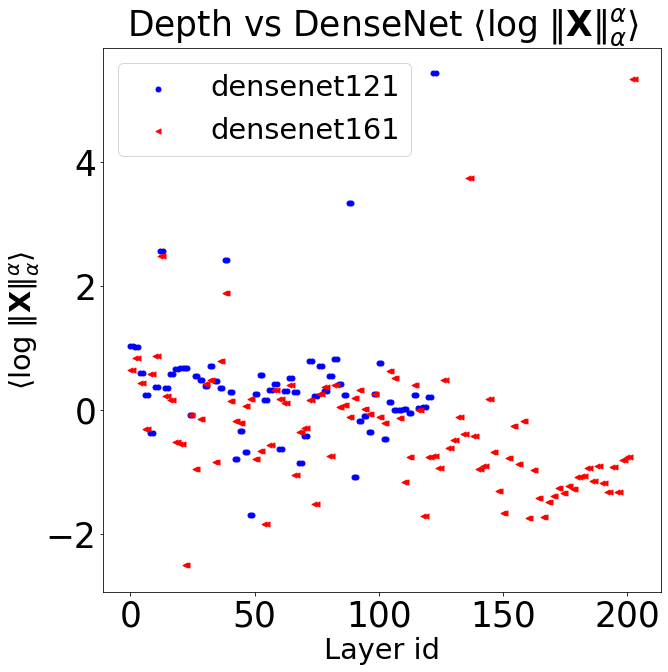

In [14]:
MP.plot_all_metric_vs_depth( \
    series_name, all_names, colors, all_summaries, all_details, first_n_last_ids)
